In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_style("darkgrid")
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Levanto los datos

df = pd.read_csv('./temperaturas/GlobalLandTemperaturesByCountry.csv')
df_lat_long = pd.read_csv('./cities_lat_long.csv')

In [3]:
print("Decripción de los datos")
print(df.describe())

print("\nLas primeras 8 filas de los datos")
print(df.head(15))

Decripción de los datos
       AverageTemperature  AverageTemperatureUncertainty
count       544811.000000                  545550.000000
mean            17.193354                       1.019057
std             10.953966                       1.201930
min            -37.658000                       0.052000
25%             10.025000                       0.323000
50%             20.901000                       0.571000
75%             25.814000                       1.206000
max             38.842000                      15.003000

Las primeras 8 filas de los datos
            dt  AverageTemperature  AverageTemperatureUncertainty Country
0   1743-11-01               4.384                          2.294   Åland
1   1743-12-01                 NaN                            NaN   Åland
2   1744-01-01                 NaN                            NaN   Åland
3   1744-02-01                 NaN                            NaN   Åland
4   1744-03-01                 NaN                        

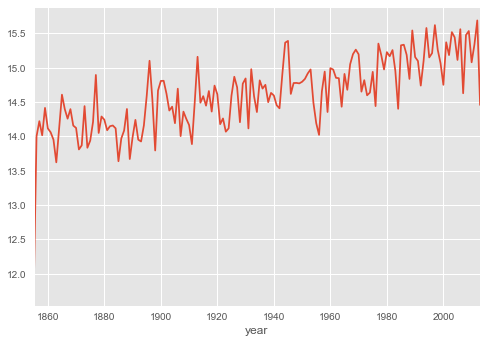

In [4]:
# Gráficos los datos

df2 = df.groupby(['Country']).get_group('Argentina')

df2['year'] = pd.DatetimeIndex(df2['dt']).year

grouped = df2.groupby(['year']).mean().reset_index()

ax = sns.tsplot(data=grouped['AverageTemperature'], time=grouped['year'], interpolate=True)
sns.plt.show()


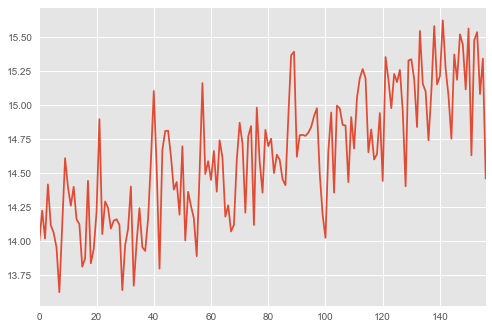

In [5]:
# Limpio los outliers

def mascara_outliers(s):
    return abs(s - s.mean()) <= 2*s.std()
    
mascara = mascara_outliers(grouped['AverageTemperature'])
grouped = grouped[mascara]
sns.tsplot(data=grouped['AverageTemperature'], interpolate=True)
sns.plt.show()

Error de predicción: 2.27


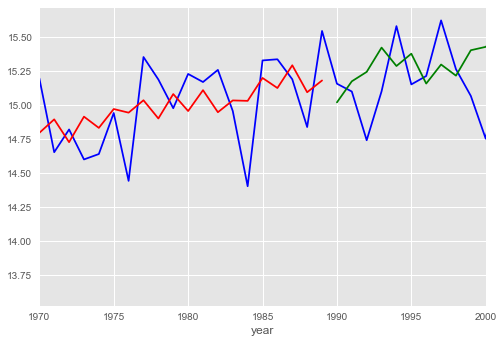

In [6]:
# Uso cuadrados mínimos para predecir
sns.tsplot(data=grouped['AverageTemperature'], time=grouped['year'], interpolate=True, color='b')


def armar_matriz_A(s):
    temp = []
    for t in s:
        temp.append([t^4, t^3, t^2, 1, np.sin(t)])
    return np.array(temp)

def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion):
    regr = linear_model.LinearRegression(fit_intercept=False)

    # Entreno el modelo
    df_e = df[df['year'].isin(rango_entrenamiento)]
    A_e = armar_matriz_A(df_e['year'])
    regr.fit(A_e, df_e['AverageTemperature'])

    # Me fijo la aproximación que se realizó
    df_e['p'] = regr.predict(A_e)
    sns.tsplot(time=df_e['year'], data=df_e['p'], color='r')

    # Realizo predicciones
    df_p = df[df['year'].isin(rango_prediccion)]

    A_p = armar_matriz_A(df_p['year'])
    df_p['p'] = regr.predict(A_p)
    sns.tsplot(time=df_p['year'], data=df_p['p'], color='g')

    ECM = sum((df_p['p']-df_p['AverageTemperature'])**2)
    return ECM

def predecir(k):
    return entrenar_y_predecir_en_rangos(grouped, range(k-20,k), range(k,k+20))
    
ECM = predecir(1990)
print("Error de predicción: {:.2f}".format(ECM))
#ECM = predecir(50)
#print("Error de predicción: {:.2f}".format(ECM))
#ECM = predecir(30)
#print("Error de predicción: {:.2f}".format(ECM))
    
sns.plt.xlim((1970,2000))
sns.plt.show()












# Y si no es una seria de tiempo? 

In [12]:
# Un par de cosas más de pandas

years = [2004]*6 + [2005]*6 + [2006]*6
delays = list(np.random.randn(6)+80) + list(np.random.randn(6)+5) + list(np.random.randn(6)+50)
delays[2] = 5
delays[7] = 80

df1 = pd.DataFrame({
    'year': years,
    'delay': delays
})

df1

,delay,year
0,80.821911,2004
1,81.994264,2004
2,5.000000,2004
3,77.742141,2004
4,80.080482,2004
5,80.356484,2004
6,4.082986,2005
7,80.000000,2005
8,5.537343,2005
9,5.836535,2005


In [13]:
# Groupby y sacar outliers

mascara = df1.groupby('year')['delay'].apply(mascara_outliers)
df1 = df1[mascara]
df1

,delay,year
0,80.821911,2004
1,81.994264,2004
3,77.742141,2004
4,80.080482,2004
5,80.356484,2004
6,4.082986,2005
8,5.537343,2005
9,5.836535,2005
10,5.402303,2005
11,5.086106,2005


In [14]:
# Groupby y calcular promedio

promedio = df1.groupby('year').aggregate(['mean', 'std', 'count'])
promedio

delay                
           mean       std count
year                           
2004  80.199056  1.556117     5
2005   5.189055  0.674536     5
2006  50.300613  0.755552     6